## Neural Network Model Building in H2O

I will go through 2 H2O  models including  GBM, and DL (Deep Learning NN).

I'll use H2OFlow for the hyperparameters searching (it's just easier than writing code) and post here the best parameters found.


# H2O

In [1]:
import pandas as pd
import numpy as np
import time
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [2]:
import h2o
import time
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [3]:
# Connect to a cluster
h2o.init()

Connecting to H2O server at http://localhost:54321....... failed.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_91"; OpenJDK Runtime Environment (build 1.8.0_91-b14); OpenJDK 64-Bit Server VM (build 25.91-b14, mixed mode)
  Starting server from /anaconda/envs/py35/h2o_jar/h2o.jar
  Ice root: /tmp/tmp62r9u06d
  JVM stdout: /tmp/tmp62r9u06d/h2o_dsvm_started_from_python.out
  JVM stderr: /tmp/tmp62r9u06d/h2o_dsvm_started_from_python.err
Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful!


In [5]:
#Let's define variables that will define the behaviour of the whole script
s3_path = 'http://bbts-kaggle.s3.amazonaws.com/bimbo/Pablo/'
use_validation=True # splits train data into train + val sets
val_week_threshold = 8 # (possible values 8 or 9)  - weeks 3,4,5,6,7 are train, and week 8.9 are val
trimmed = True # removes weeks which doesn't have all the lags. If False, fills empty lags with 0
lag = 5  # shifted mean_demand up to "lag" weeks
if (val_week_threshold == 8): lag = 4

In [6]:
#now we load our modified train and test set
tic()
sufix=""
sufix=""
if (use_validation): 
    sufix += "_holdout"
    sufix += repr(val_week_threshold)
if (trimmed): sufix += "_trimmed"

#train_csv = s3_path +"train_modified"+sufix+".csv"
#val_csv = s3_path +"val_modified"+sufix+".csv"
#test_csv = s3_path +"test_modified"+sufix+".csv"

train_csv = s3_path +"jorge_train.csv"
val_csv = s3_path +"jorge_test.csv"
test_csv = s3_path +"jorge_validation.csv"

tic()
print ('Downloading File: {} ...'.format(train_csv))
train = h2o.import_file(train_csv)

if (use_validation):
    print ('Downloading File: {} ...'.format(val_csv))
    val = h2o.import_file(val_csv)
    
print ('Downloading File: {} ...'.format(test_csv))
test = h2o.import_file(test_csv)
tac()




Time passed: 0hour:5min:22sec


In [11]:
train.show()

C1,Agencia_ID,Canal_ID,Cliente_ID,Demanda_uni_equil,Producto_ID,Ruta_SAK,Semana,ZipCode,id,Last_per_Cliente_ID,Last_per_Ruta_SAK,week_ct,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum,brand,Qty_Ruta_SAK_Bin,num_prod,num_prod_uni,log_target
0,1110,7,15766,1.38629,1212,3301,3,2008,0,1.60944,0,3,0,0,0,0,0,2,1,23,23,0.869742
1,1110,7,15766,1.60944,1216,3301,3,2008,0,0,0,3,0,0,0,0,0,2,1,23,23,0.959135
2,1110,7,15766,1.60944,1238,3301,3,2008,0,0,0,3,0,0,0,0,0,2,1,23,23,0.959135
3,1110,7,15766,1.60944,1240,3301,3,2008,0,1.09861,0,3,0,0,0,0,0,2,1,23,23,0.959135
4,1110,7,15766,1.38629,1242,3301,3,2008,0,1.09861,0,3,0,0,0,0,0,2,1,23,23,0.869742
5,1110,7,15766,1.79176,1250,3301,3,2008,0,0.693147,0,3,0,0,0,0,0,2,1,23,23,1.02667
6,1110,7,15766,1.38629,1309,3301,3,2008,0,1.79176,0,3,0,0,0,0,0,2,1,23,23,0.869742
7,1110,7,15766,1.94591,3894,3301,3,2008,0,2.3979,0,3,0,0,0,0,0,14,1,23,23,1.08042
8,1110,7,15766,1.60944,4085,3301,3,2008,0,2.3979,1.53796,3,0,0,0,0,0,14,1,23,23,0.959135
9,1110,7,15766,1.94591,5310,3301,3,2008,0,2.3979,0,3,0,0,0,0,0,14,1,23,23,1.08042


In [9]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

In [10]:
#Create our target column
train[target] = train['Demanda_uni_equil'].log1p()

In [12]:
def modelfit(alg, dtrain, dval, dtest, predictors, target, IDcol, filename):   
    #Fit the algorithm on the data
    alg.train(x=predictors, y=target, training_frame=dtrain, validation_frame=dval)
    
    dtrain_df = pd.DataFrame()
    dval_df = pd.DataFrame()
    
    #Predict training set:
    dtrain_df = alg.predict(dtrain[predictors]).as_data_frame(use_pandas=True) #H2O automatically names the column "predict"
    dtrain_df["predict"] = np.maximum(dtrain_df["predict"], 0)
    
    #Predict validation (holdout) set:
    dval_df = alg.predict(dval[predictors]).as_data_frame(use_pandas=True)
    dval_df["predict"] = np.maximum(dval_df["predict"], 0)
    
    #Performance on Training and Val sets:
    print ("\nModel Report")
    print ('RMSLE TRAIN: ', np.sqrt(metrics.mean_squared_error(dtrain[target].as_data_frame(use_pandas=True), dtrain_df["predict"] )))
    print ('RMSLE VAL: ', np.sqrt(metrics.mean_squared_error(dval[target].as_data_frame(use_pandas=True), dval_df["predict"] )))
 
    #Predict on testing data: we need to revert it back to "Demanda_uni_equil" by applying expm1 
    dtest[target] = alg.predict(dtest).expm1()
    
    print ('NUM ROWS PREDICTED: ', dtest.shape[0] )
    print ('MIN TARGET PREDICTED: ', dtest[target].min())
    print ('MEAN TARGET PREDICTED: ', dtest[target].mean())
    print ('MAX TARGET PREDICTED: ', dtest[target].max())
    
    
    #Export submission file:
    submission = dtest[[IDcol,target]].as_data_frame(use_pandas=True)
    submission[target] = np.maximum(submission[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)

Let's define now the target and the Id cols

In [13]:
#H@O would automatically hot-encode the categorical values (Genius!), but we must specify what columns are categoricals
train['brand'] = train['brand'].asfactor()
train['ZipCode'] = train['ZipCode'].asfactor()
train['week_ct'] = train['week_ct'].asfactor()

In [14]:
# In case there is no validation, we make val = train
if not (use_validation):
    val = train

### Alg8 - GBM

Lets make our first GBM model

In [ ]:
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4',
              'Last_per_Cliente_ID', 'Last_per_Ruta_SAK',
              'Lags_sum', 'brand', 'week_ct', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'num_prod', 'num_prod_uni']


model = H2OGradientBoostingEstimator(ntrees=300,max_depth=10,learn_rate=0.1, min_rows=10, nbins=40, sample_rate=0.7,
                                    col_sample_rate=0.7, stopping_rounds=10, stopping_metric="MSE", stopping_tolerance=0.01)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg8_{}.csv'.format(sufix).csv)
tac()

model.varimp(use_pandas=True)
#Plot Coeficients importance
#coef = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
#coef.plot(kind='bar', title='Feature Importances')

#Plot Histogram of target and prediction distributions
plt.hist(val['log_target'], 100, alpha=0.5, label='target')
plt.hist(val['predictions'], 100, alpha=0.5, label='predictions') 
plt.legend(loc='upper right')
plt.show()

#Plots Training Scoring history
model.plot(metric='rmse')

## --> LB: 

### Alg9 - Deep Learning

Now we try with a Deep Learning Network. To improve generalization we added dropout and L1 and L2 penalties.

In [ ]:
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
              'Agencia_ID','Ruta_SAK','Cliente_ID','Producto_ID',
              'Lags_sum', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'Producto_ID_clust_ID']

model = H2ODeepLearningEstimator(activation="Rectifier", hidden=[100,100,100], epochs=35,
                                standardize=False, score_interval=10, stopping_rounds=10, stopping_metric="MSE",
                                stopping_tolerance=0.01, use_all_factor_levels=False)
    
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg9_{}.csv'.format(sufix).csv)
tac()

model.varimp(use_pandas=True)
#Plot Coeficients importance
#coef = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
#coef.plot(kind='bar', title='Feature Importances')

#Plot Histogram of target and prediction distributions
plt.hist(val['log_target'], 100, alpha=0.5, label='target')
plt.hist(val['predictions'], 100, alpha=0.5, label='predictions') 
plt.legend(loc='upper right')
plt.show()

#Plots Training Scoring history
model.plot(metric='rmse')

In [12]:
model_history_df = model.scoring_history()
model_history_df

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mae,training_deviance,validation_rmse,validation_deviance,validation_mae
0,,2016-08-28 09:58:46,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2016-08-28 09:58:49,49.404 sec,54310 rows/sec,0.009571,1,99606.0,0.555816,0.308931,0.419092,0.557049,0.310304,0.420002
2,,2016-08-28 10:02:14,4 min 16.188 sec,64966 rows/sec,1.008705,105,10497458.0,0.744095,0.553677,0.554258,0.728426,0.530605,0.543974
3,,2016-08-28 10:03:01,5 min 3.014 sec,64963 rows/sec,1.008705,105,10497458.0,0.555816,0.308931,0.419092,0.557049,0.310304,0.420002


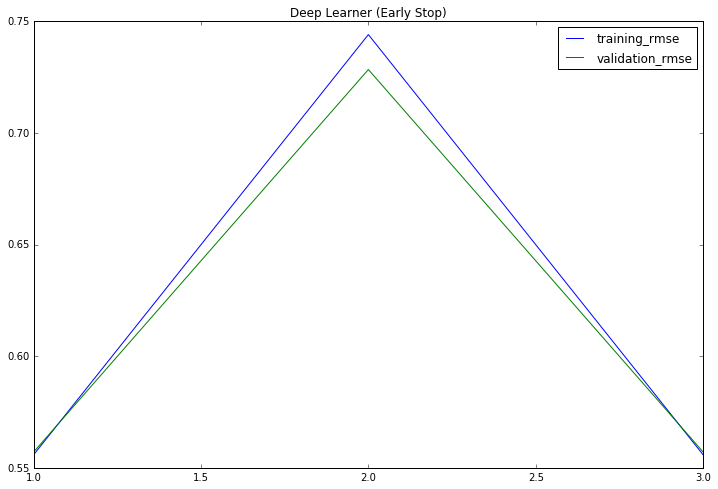

In [13]:
plt.plot(model_history_df['training_rmse'], label="training_rmse")
plt.plot(model_history_df['validation_rmse'], label="validation_rmse")
plt.title("Deep Learner .. )")
plt.legend();